# 110th Congress Data

This notebook is meant to call, clean, and examine data from the 2006 election, to produce a viable metric correlating PVI and electoral success.

It feeds into a larger project about fairness in redistricting; for instance, if an R+15 district is unattainable for a Democrat to win, then the district can be wholly classified as "safe," and should be bucketed with R+30 district.

The nuance enters in the margins. How safe is an R+6 district for instance? Can we quantify a district moving from R+3 to R+6 as a significant bias against Democrats? By cleaning this dataset, and others like it, we can determine the predictive power of PVI in each district, and use those probabilities later to assess redistricting fairness.

## Retrieve data from Wikipedia

Wikipedia's current Cook PVI page contains a free and current (up to 2020 election results) version of the index, where free downloads from Cook's website are dated, containing 2018 results and 2016 PVI metrics

In [1]:
import requests
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
#import and format url
url = "https://web.archive.org/web/20080821045325/https://en.wikipedia.org/wiki/Cook_Partisan_Voting_Index"
page = pd.read_html(url)
dat = pd.concat(page,ignore_index=True)

In [3]:
#split data into state and district pvis
    #wiki_district = dat[7:443]
    #wiki_state = dat[448:]
#Scraping is not functional, load in via csv
wiki_district = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/raw_data/pvi_110.csv")
wiki_state = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/raw_data/state_110.csv")
print(wiki_state.columns)
print(wiki_district.columns)

Index(['State  ', 'PVI  '], dtype='object')
Index(['State  ', 'District', 'PVI  ', 'Party\nin Congress  '], dtype='object')


In [4]:
#seeing issue with column names with spaces, rename columns
wiki_state.columns = ['State', 'PVI']
wiki_district.columns = ['State', 'District', 'PVI', 'Representative']
print(wiki_state.columns)
print(wiki_district.columns)

Index(['State', 'PVI'], dtype='object')
Index(['State', 'District', 'PVI', 'Representative'], dtype='object')


In [5]:
#cut NA columns
wiki_district = wiki_district.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
wiki_state = wiki_state.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
#remove DC from the state list
wiki_state = wiki_state[wiki_state.State != "District of Columbia"].reset_index()

In [6]:
#check the various datasets
print(wiki_district.tail(1))
print(wiki_district.head(1))
print(wiki_state.tail(1))
print(wiki_state.head(1))

       State  District   PVI Representative
434  Wyoming  At-large  R+19     Republican
     State District   PVI Representative
0  Alabama      1st  R+12     Republican
    index    State   PVI
49     50  Wyoming  R+19
   index    State  PVI
0      0  Alabama  R+8


## Clean and Organize State Data

In [7]:
#call in a dictionary of state abbreviations
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [8]:
state_110 = wiki_state
state_110["ST"] =  state_110["State"]
#abbreviate the ST coulmn
state_110 = state_110.replace({"ST": us_state_to_abbrev})
#check that both ST and num function apropriatley
print(state_110["ST"].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN'
 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


In [9]:
#split out pvi by party and weight
#first eliminate even values
state_110["PVI"] = state_110["PVI"].str.replace("EVEN","R+0")
state_110["pvi_party"] = state_110.PVI.str[0]
state_110['partisan_weight'] = state_110['PVI'].str.split('+').str[1]
#check results
print(state_110.head(n=1))
print(state_110["pvi_party"].unique())

   index    State  PVI  ST pvi_party partisan_weight
0      0  Alabama  R+8  AL         R               8
['R' 'D']


In [10]:
#add constants for later aggregation
state_110["year"] = 2006
state_110["congress"] = 110

In [11]:
#create a variable that is negative when the party is democratic
state_110["neg"] = state_110['pvi_party'].str.replace('D','-')
state_110["neg"] = state_110["neg"].str.replace('R','')
#ensure partisan weight has a negative value for democratic leaning and a positive value for Republican leaning
state_110['partisan_weight'] = state_110["neg"] + state_110['partisan_weight']
#ensure values are integers
state_110['partisan_weight'] = state_110['partisan_weight'].astype(int)

In [12]:
state_110["metric"] = ((state_110['partisan_weight'] / 2) + 50) / 100
state_110.head(n=7)

,index,State,PVI,ST,pvi_party,partisan_weight,year,congress,neg,metric
0,0,Alabama,R+8,AL,R,8,2006,110,,0.540
1,1,Alaska,R+14,AK,R,14,2006,110,,0.570
2,2,Arizona,R+1,AZ,R,1,2006,110,,0.505
3,3,Arkansas,R+3,AR,R,3,2006,110,,0.515
4,4,California,D+6,CA,D,-6,2006,110,-,0.470
5,5,Colorado,R+1,CO,R,1,2006,110,,0.505
6,6,Connecticut,D+9,CT,D,-9,2006,110,-,0.455


In [13]:
state_110 = state_110[["year","ST","PVI","metric"]]
state_109 = state_110
state_110.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_110.csv",index=False)
state_109.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_109.csv",index=False)

In [14]:
state_110.head(8)

,year,ST,PVI,metric
0,2006,AL,R+8,0.540
1,2006,AK,R+14,0.570
2,2006,AZ,R+1,0.505
3,2006,AR,R+3,0.515
4,2006,CA,D+6,0.470
5,2006,CO,R+1,0.505
6,2006,CT,D+9,0.455
7,2006,DE,D+7,0.465


## Clean and Organize the District Data

In [15]:
import numpy as np
import plotnine as p9
from plotnine import ggplot, aes, facet_grid, labs, geom_point, geom_smooth
from sklearn.linear_model import LinearRegression as lm
import warnings
warnings.filterwarnings('ignore')

In [16]:
#load in and check the data
pvi_110 = wiki_district
print(pvi_110.head(n=1))
print(pvi_110.shape)

     State District   PVI Representative
0  Alabama      1st  R+12     Republican
(435, 4)


In [17]:
#correct the column name for later use
pvi_110 = pvi_110.rename(columns={"Party of\nRepresentative": "Representative"})

In [18]:
#fix at large designation
pvi_110['District'] = pvi_110['District'].str.replace('at-large','AL')
pvi_110.head(n=8)

,State,District,PVI,Representative
0,Alabama,1st,R+12,Republican
1,Alabama,2nd,R+13,Republican
2,Alabama,3rd,R+4,Republican
3,Alabama,4th,R+16,Republican
4,Alabama,5th,R+6,Democratic
5,Alabama,6th,R+25,Republican
6,Alabama,7th,D+17,Democratic
7,Alaska,At-large,R+14,Republican


In [19]:
#fix at large designation
pvi_110['District'] = pvi_110['District'].str.replace('At-large','AL')
pvi_110['District'] = pvi_110['District'].str.rstrip("st")
pvi_110['District'] = pvi_110['District'].str.rstrip("nd")
pvi_110['District'] = pvi_110['District'].str.rstrip("rd")
pvi_110['District'] = pvi_110['District'].str.rstrip("th")
pvi_110.head(n=8)

,State,District,PVI,Representative
0,Alabama,1,R+12,Republican
1,Alabama,2,R+13,Republican
2,Alabama,3,R+4,Republican
3,Alabama,4,R+16,Republican
4,Alabama,5,R+6,Democratic
5,Alabama,6,R+25,Republican
6,Alabama,7,D+17,Democratic
7,Alaska,AL,R+14,Republican


In [20]:
#seperate state and district
pvi_110["num"] = pvi_110.District
pvi_110["ST"] =  pvi_110["State"]
pvi_110.head(n=1)

,State,District,PVI,Representative,num,ST
0,Alabama,1,R+12,Republican,1,Alabama


In [21]:
#abbreviate the ST coulmn
pvi_110 = pvi_110.replace({"ST": us_state_to_abbrev})
#check that both ST and num function apropriatley
print(pvi_110["ST"].unique())
print(pvi_110["num"].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN'
 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']
['1' '2' '3' '4' '5' '6' '7' 'AL' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53']


In [22]:
#create the district code variable
pvi_110["ST#"] = pvi_110["ST"] + pvi_110["num"]
#create the "party of represenative" variable
pvi_110["seat"] = pvi_110.Representative.str[0]
#make a dummy
pvi_110["is_GOP"] = pvi_110["seat"].replace("R",1)
pvi_110["is_GOP"] = pvi_110["is_GOP"].replace("D",0)
#The seats of Charlie Dent and Pat Meehan in Pennsylvania went R -> D during this time frame
#covert to integer for later numeric analysis
pvi_110["is_GOP"] = pvi_110["is_GOP"].astype(int)
pvi_110.head(n=7)
print(pvi_110["is_GOP"].unique())

[1 0]


In [23]:
#possibly unneccessary
#pull out district lean
pvi_110["lean"] = pvi_110.PVI.str[0]
pvi_110["lean"].unique()

array(['R', 'D'], dtype=object)

In [24]:
#split out pvi by party and weight
#first eliminate even values
pvi_110["PVI"] = pvi_110["PVI"].str.replace("EVEN","R+0")
pvi_110["pvi_party"] = pvi_110.PVI.str[0]
pvi_110['partisan_weight'] = pvi_110['PVI'].str.split('+').str[1]
#check results
print(pvi_110.head(n=1))
print(pvi_110["pvi_party"].unique())

     State District   PVI Representative num  ST  ST# seat  is_GOP lean  \
0  Alabama        1  R+12     Republican   1  AL  AL1    R       1    R   

  pvi_party partisan_weight  
0         R              12  
['R' 'D']


In [25]:
#create a variable that is negative when the party is democratic
pvi_110["neg"] = pvi_110['pvi_party'].str.replace('D','-')
pvi_110["neg"] = pvi_110["neg"].str.replace('R','')
#ensure partisan weight has a negative value for democratic leaning and a positive value for Republican leaning
pvi_110['partisan_weight'] = pvi_110["neg"] + pvi_110['partisan_weight']
#ensure values are integers
pvi_110['partisan_weight'] = pvi_110['partisan_weight'].astype(int)

In [26]:
pvi_110["metric"] = ((pvi_110['partisan_weight'] / 2) + 50) / 100
pvi_110.head(n=7)

,State,District,PVI,Representative,num,ST,ST#,seat,is_GOP,lean,pvi_party,partisan_weight,neg,metric
0,Alabama,1,R+12,Republican,1,AL,AL1,R,1,R,R,12,,0.560
1,Alabama,2,R+13,Republican,2,AL,AL2,R,1,R,R,13,,0.565
2,Alabama,3,R+4,Republican,3,AL,AL3,R,1,R,R,4,,0.520
3,Alabama,4,R+16,Republican,4,AL,AL4,R,1,R,R,16,,0.580
4,Alabama,5,R+6,Democratic,5,AL,AL5,D,0,R,R,6,,0.530
5,Alabama,6,R+25,Republican,6,AL,AL6,R,1,R,R,25,,0.625
6,Alabama,7,D+17,Democratic,7,AL,AL7,D,0,D,D,-17,-,0.415


In [27]:
#add constants for later aggregation
pvi_110["year"] = 2006
pvi_110["congress"] = 110

In [37]:
#create a new datasets for the district PVIs from the previoys congress
pvi_only_109 = pvi_110[["ST#","PVI","metric"]]
pvi_only_109["year"] = 2004
pvi_only_109["congress"] = 109
pvi_only_109.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/raw_data/pvi_only_109.csv",index=False)

## Export clean versions of the data

In [29]:
#create a dataset solely to correlate pvi with the holder of the seat
pure_110 = 
pure_110.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/pure_datasets/pure_110.csv",index=False)
#create a more detailed dataset for greater uses
data_110 = pvi_110[["year","congress","ST","ST#","seat","is_GOP","PVI","metric"]]
data_110.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_110.csv",index=False)

In [30]:
data_110.head(8)

,year,congress,ST,ST#,seat,is_GOP,PVI,metric
0,2004,109,AL,AL1,R,1,R+12,0.560
1,2004,109,AL,AL2,R,1,R+13,0.565
2,2004,109,AL,AL3,R,1,R+4,0.520
3,2004,109,AL,AL4,R,1,R+16,0.580
4,2004,109,AL,AL5,D,0,R+6,0.530
5,2004,109,AL,AL6,R,1,R+25,0.625
6,2004,109,AL,AL7,D,0,D+17,0.415
7,2004,109,AK,AKAL,R,1,R+14,0.570


## Conduct preliminary examinations of the data

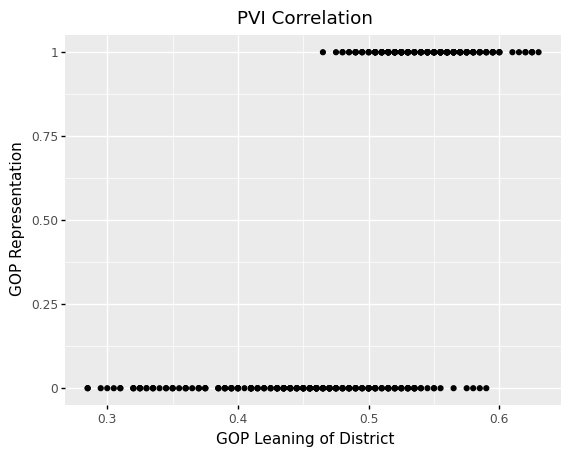

<ggplot: (8779618592353)>

In [31]:
# Create a super simple scatterplot to examine the relationship between PVI and congressional district
(p9.ggplot(data=pure_110, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y='GOP Representation',color="",title="PVI Correlation"))

In [32]:
#group by metric and average GOP seats
bm_110 = pure_110.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_110 = bm_110.reset_index()

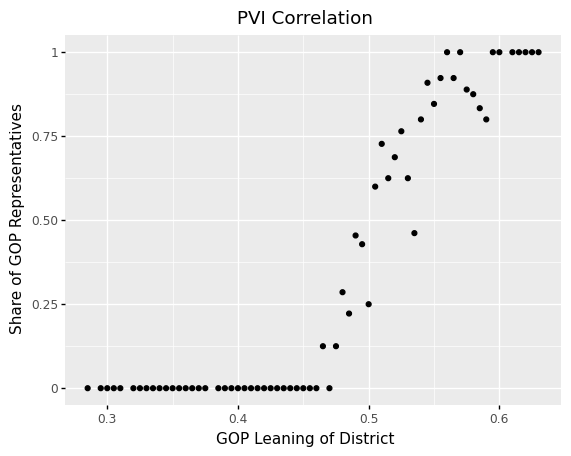

<ggplot: (8779595922062)>

In [33]:
#Plot averages
(p9.ggplot(data=bm_110, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

In [34]:
#now lets limit the data to only the R+10 to D+10 range, calling it Limited Domain
ld_110 = bm_110[bm_110["metric"] <= .55]
ld_110 = ld_110[ld_110["metric"] >= .45]

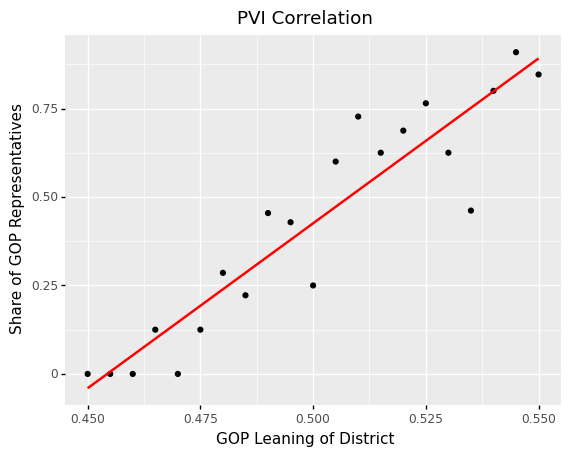

<ggplot: (8779596205927)>

In [35]:
#Plot averages
(p9.ggplot(data=ld_110, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + geom_smooth(method = "lm", color = "red", se = False)
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))